In [1]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns

import numpy as np
from datetime import datetime
import os

In [2]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.5,
                        wspace=0.4,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

In [55]:
def plot_eval_metrics(fig_title,
                      df,
                      y_col_name,
                      plot_ratio_active_gps=False,
                      save_fig=False,
                      save_dir="../figures",
                      file_name="benchmarking_metrics.png"):
    # Compute evaluation metric ranks and use total rank for sorting
    val_mse_score_ranks = (df.groupby([y_col_name])
                           ["val_mse_score"].mean().rank(ascending=True)
                           .rename("val_mse_score_rank"))
    val_auroc_score_ranks = (df.groupby([y_col_name])
                                ["val_auroc_score"].mean().rank(ascending=False)
                                .rename("val_auroc_score_rank"))
    df = df.merge(val_mse_score_ranks, on=[y_col_name])
    df = df.merge(val_auroc_score_ranks, on=[y_col_name])
    df["val_total_score_rank"] = (df["val_mse_score_rank"] + 
                                  df["val_auroc_score_rank"]).rank(ascending=True)

    df.sort_values(by=["val_mse_score_rank", y_col_name],
                   inplace=True,
                   ascending=False)
    
    if plot_ratio_active_gps:
        fig, axes = plt.subplots(3, 1, sharey=True, figsize=(10, 20))
        
        # Ratio active gene programs
        sns.boxplot(data=df, ax=axes[2], x="ratio_active_gps", y=y_col_name)
        axes[2].set_title("Ratio of Active Gene Programs")
    else:
        fig, axes = plt.subplots(2, 1, sharey=True, figsize=(10, 15))
    fig.suptitle(fig_title, fontsize=15)
    
    # Edge reconstruction performance
    sns.boxplot(data=df, ax=axes[0], x="val_auroc_score", y=y_col_name)
    axes[0].set_title("Edge Reconstruction Area Under ROC Curve")

    # Gene expression reconstruction performance
    sns.boxplot(data=df, ax=axes[1], x="val_mse_score", y=y_col_name)
    axes[1].set_title("Gene Expression Reconstruction Mean Squared Error")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.94,
                        wspace=0.175,
                        hspace=0.175)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}",
                    bbox_inches='tight')


def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

def get_active_gp_group_lasso_comb(row):
    return f"active_gp_thresh_{row['active_gp_thresh_ratio_']}_+_group_lasso_{row['lambda_group_lasso_']}"

df["active_gp_group_lasso_comb"] = df.apply(lambda row: get_active_gp_group_lasso_comb(row), axis=1)

In [50]:
experiment_name = "benchmark_loss_weights"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

def get_loss_weights(row):  
    return f"lambda_edge_recon_{row['lambda_edge_recon_']}_+_lambda_gene_expr_recon_{row['lambda_gene_expr_recon_']}"
df["loss_weights"] = df.apply(lambda row: get_loss_weights(row), axis=1)

In [ ]:
df = df[df["avg_n_neighbors"] == "4.0"]

In [51]:
df = df[df["encoder_n_attention_heads_"] == "0"]

In [ ]:
len(df[(df["avg_n_neighbors"] == "4.0") & (df["conv_layer_encoder_"] == "gcnconv")])

In [53]:
df

,dataset,n_nodes,n_genes,gp_mask,nichenet_keep_target_ratio,omnipath_min_curation_effort,gp_filter_mode,combine_overlap_gps,overlap_thresh_source_genes,overlap_thresh_target_genes,...,n_nonaddon_gps_,n_output_,node_label_method_,val_mse_score,val_auroc_score,val_auprc_score,val_best_acc_score,val_best_f1_score,n_active_gps,loss_weights
0,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,NaN,NaN,NaN,NaN,NaN,NaN,lambda_edge_recon_0_+_lambda_gene_expr_recon_1.0
1,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,0.578768,0.500064,0.500032,0.500064,0.666695,489.0,lambda_edge_recon_0_+_lambda_gene_expr_recon_1.0
3,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,0.674596,0.996472,0.993511,0.959701,0.961253,489.0,lambda_edge_recon_1.0_+_lambda_gene_expr_recon...
4,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,0.674273,0.996511,0.993614,0.959379,0.960960,489.0,lambda_edge_recon_1.0_+_lambda_gene_expr_recon...
5,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,0.678519,0.997048,0.995410,0.977598,0.978080,489.0,lambda_edge_recon_1.0_+_lambda_gene_expr_recon...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,1.211494,0.784047,0.698865,0.676289,0.755070,489.0,lambda_edge_recon_0.2_+_lambda_gene_expr_recon...
174,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,1.206740,0.717322,0.639044,0.638660,0.734369,489.0,lambda_edge_recon_0.1_+_lambda_gene_expr_recon...
175,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,1.219718,0.725368,0.645636,0.649485,0.740260,489.0,lambda_edge_recon_0.1_+_lambda_gene_expr_recon...
176,squidpy_seqfish_mouse_organogenesis,19416,351,combined_priors,0.01,0,subset,True,0.9,0.9,...,489,702,one-hop-attention,1.224727,0.502577,0.501292,0.501546,0.667355,489.0,lambda_edge_recon_0_+_lambda_gene_expr_recon_1.0


In [ ]:
df[["lambda_edge_recon_", "lambda_gene_expr_recon_", "encoder_n_attention_heads_", "conv_layer_encoder_", "avg_n_neighbors"]].head(20)

In [ ]:
plot_eval_metrics(fig_title="Number of Neighbors Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="avg_n_neighbors",
                  plot_ratio_active_gps=False,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

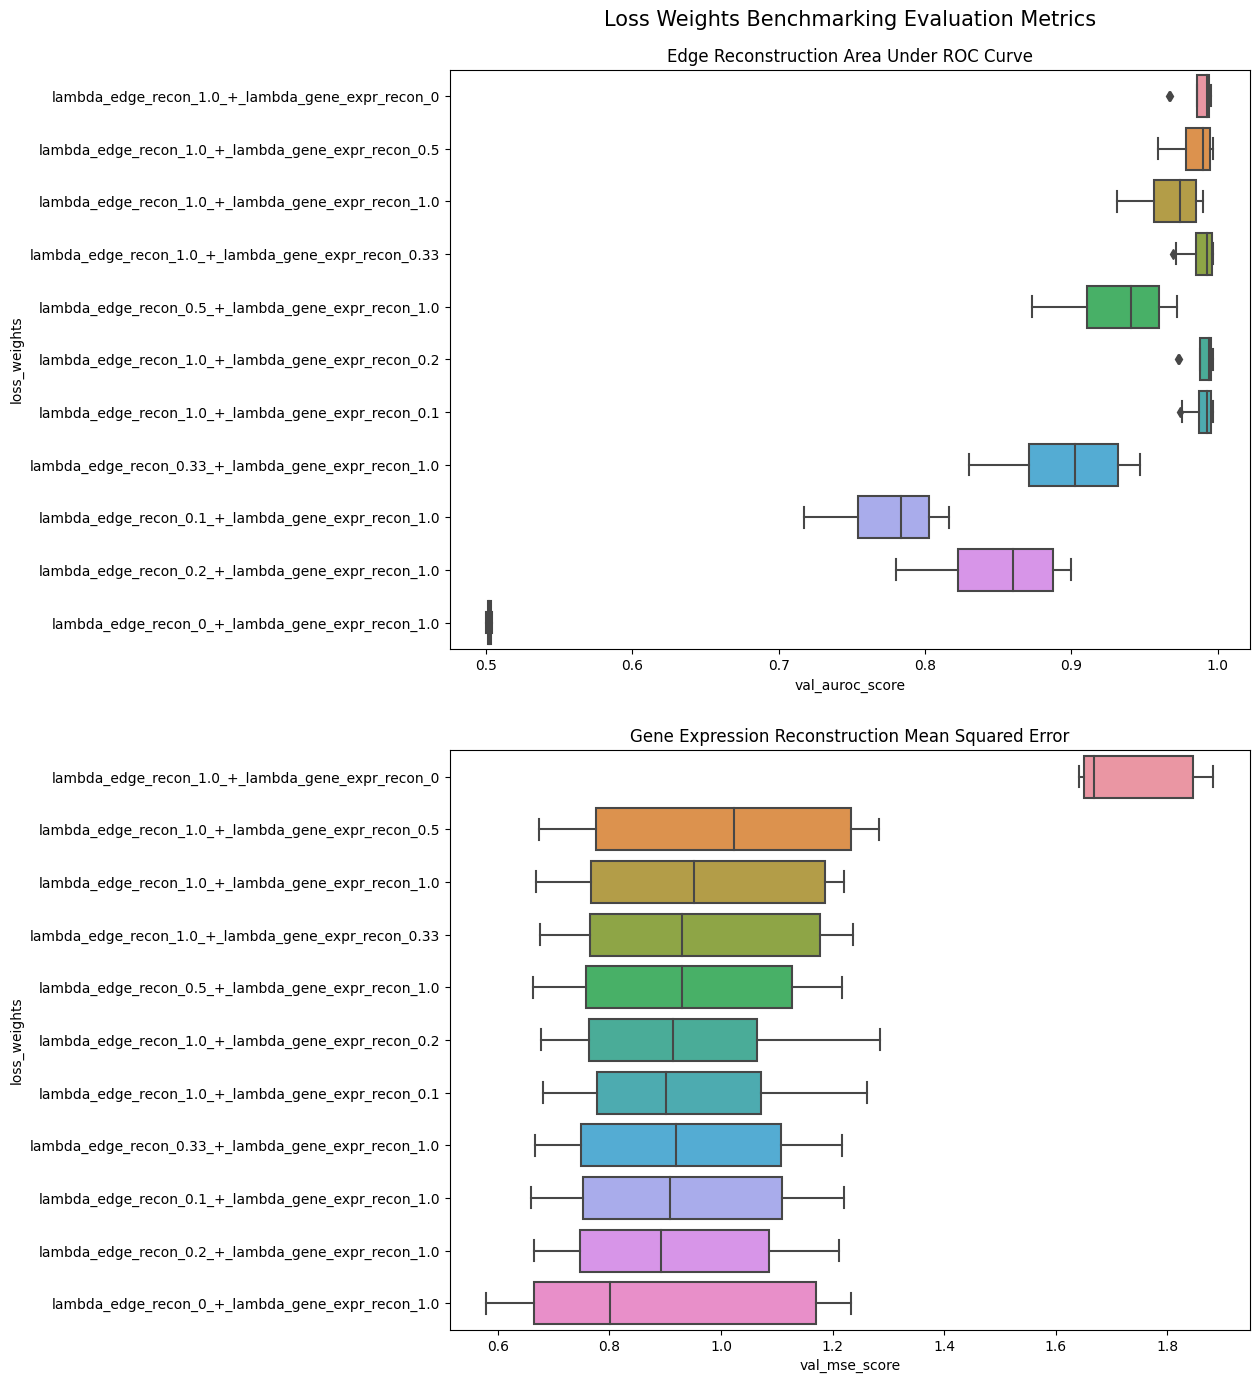

In [56]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  plot_ratio_active_gps=False,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

In [ ]:
experiment_name = "benchmark_encoder_decoder_arch"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

def get_layer_encoder(row):  
    return f"conv_layer_encoder_{row['conv_layer_encoder_']}_+_encoder_n_attention_heads_{row['encoder_n_attention_heads_']}"
df["layer_encoder"] = df.apply(lambda row: get_layer_encoder(row), axis=1)

In [ ]:
df = df[df["lambda_gene_expr_recon_"] != "1"]

In [ ]:
df["lambda_gene_expr_recon_"]

In [ ]:
plot_eval_metrics(fig_title="Encoder Layer Benchmarking Evaluation Metrics",
                  df=df,
                  y_col_name="layer_encoder",
                  plot_ratio_active_gps=False,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

In [ ]:
df[df["lambda_gene_expr_recon_"] != '1.0'][["lambda_edge_recon_", "lambda_gene_expr_recon_", "encoder_n_attention_heads_", "conv_layer_encoder_"]]

In [ ]:
df = df[df["lambda_group_lasso_"].astype(float) == 0]

In [ ]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  plot_ratio_active_gps=False,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

In [ ]:
df[["lambda_edge_recon_", "lambda_gene_expr_recon_", "avg_n_neighbors"]]

In [ ]:
experiment_name = "benchmark_active_gps"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
# Get active gene program ratio
def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))
df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

# Get combination of active gene program threshold and lambda group lasso
def get_active_gp_thresh_lambda_group_lasso(row):
    return f"active_gp_thresh_{row['active_gp_thresh_ratio_']}_+_lambda_group_lasso_{row['lambda_group_lasso_']}"
df["active_gp_thresh_lambda_group_lasso"] = df.apply(lambda row: get_active_gp_thresh_lambda_group_lasso(row), axis=1)

df = df[(df["lambda_edge_recon_"].astype(float) == 1.0) & 
        (df["lambda_gene_expr_recon_"].astype(float) == 1.0) &
        (df["n_active_gps"].notna())]

In [ ]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="active_gp_thresh_lambda_group_lasso",
                  plot_ratio_active_gps=True,
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_active_gps",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=False)

In [ ]:
experiment_name = "benchmark_encoder_decoder_arch"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
experiment_name = "benchmark_mixed"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
len(df)

In [ ]:
df.sort_values(by="val_best_acc_score", ascending=False)[["val_best_acc_score", "val_mse_score", "lambda_edge_recon_", "gene_expr_recon_dist_", "node_label_method_", "conv_layer_encoder_", "encoder_n_attention_heads_"]]

In [ ]:
def get_encoder_decoder_arch(row):
    return f"encoder_layer_{row['conv_layer_encoder_']}_+_node_label_method_{row['node_label_method_']}_+_gene_expr_dist_{row['gene_expr_recon_dist_']}"

df["encoder_decoder_arch"] = df.apply(lambda row: get_encoder_decoder_arch(row), axis=1)

def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

In [ ]:
plot_eval_metrics(fig_title="Encoder Decoder Architecture Benchmarking Metrics",
                  df=df,
                  y_col_name="encoder_decoder_arch",
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_encoder_decoder_arch",
                  file_name="active_gp_eval_metrics.png",
                  save_fig=True)

In [ ]:
experiment_name = "benchmark_encoder_decoder_arch2"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
def get_conv_layer_encoder(row):
    return f"conv_layer_{row['conv_layer_encoder_']}_+_n_attention_heads_{row['encoder_n_attention_heads_']}"
df["conv_layer_encoder"] = df.apply(lambda row: get_conv_layer_encoder(row), axis=1)

def get_ratio_active_gps(row):
    return row["n_active_gps"] / (int(row["n_nonaddon_gps_"]) + int(row["n_addon_gps_"]))

df["ratio_active_gps"] = df.apply(lambda row: get_ratio_active_gps(row), axis=1)

In [ ]:
df_avg_n_neighbors_8 = df[df["avg_n_neighbors"].astype(float) == 8]
df_avg_n_neighbors_8 = df[df["avg_n_neighbors"].astype(float) == 4]

In [ ]:
df["avg_n_neighbors"]

In [ ]:
plot_eval_metrics(fig_title="Encoder Decoder Architecture Benchmarking Metrics",
                  df=df,
                  y_col_name="conv_layer_encoder",
                  save_dir="../figures/squidpy_seqfish_mouse_organogenesis/benchmarking/benchmark_encoder_decoder_arch2",
                  file_name="eval_metrics.png",
                  save_fig=False)

In [ ]:
df.columns

In [ ]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="loss_weights",
                  save_fig=False)

In [ ]:
plot_eval_metrics(fig_title="Loss Weights Benchmarking Metrics",
                  df=df,
                  y_col_name="active_gp_group_lasso_comb",
                  save_fig=False)

In [ ]:
plot_benchmarking_metrics(fig_title="Loss Weights Benchmarking Metrics",
                          df=df,
                          y_col_name="loss_weights",
                          save_fig=False)

In [ ]:
sns.boxplot(data=df, x="test_best_acc_score", y="loss_weights")

In [ ]:
def get_recon_loss_inclusion(row):  
    if row["include_edge_recon_loss_"] == "True" and row["include_gene_expr_recon_loss_"] == "True":
        return "edge_+_gene_expr"
    elif row["include_edge_recon_loss_"] == "True" and row["include_gene_expr_recon_loss_"] == "False":
        return "only_edge"
    elif row["include_edge_recon_loss_"] == "False" and row["include_gene_expr_recon_loss_"] == "True":
        return "only_gene_expr"
    return "none"

df["recon_loss_inclusions"] = df.apply(lambda row: get_recon_loss_inclusion(row), axis=1)

In [ ]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Reconstruction Loss Inclusion Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="recon_loss_inclusions")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="recon_loss_inclusions")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="recon_loss_inclusions")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="recon_loss_inclusions")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="recon_loss_inclusions")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="recon_loss_inclusions")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
experiment_name = "benchmark_gene_expr_recon"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
def get_gene_expr_recon_components(row):  
    if row["node_label_method_"] == "self" and row["conv_layer_encoder_"] == "gcnconv":
        return "self_+_nb"
    elif row["node_label_method_"] == "self" and row["gene_expr_recon_dist_"] == "zinb":
        return "self_+_zinb"
    elif row["node_label_method_"] == "one-hop-sum" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-sum_+_nb"
    elif row["node_label_method_"] == "one-hop-sum" and row["gene_expr_recon_dist_"] == "zinb":
        return "one-hop-sum_+_zinb"
    elif row["node_label_method_"] == "one-hop-norm" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-norm_+_nb"
    elif row["node_label_method_"] == "one-hop-norm" and row["gene_expr_recon_dist_"] == "zinb":
        return "one-hop-norm_+_zinb"
    elif row["node_label_method_"] == "one-hop-attention" and row["gene_expr_recon_dist_"] == "nb":
        return "one-hop-attention_+_nb"
    return "one-hop-attention_+_zinb"

df["gene_expr_recon_components"] = df.apply(lambda row: get_gene_expr_recon_components(row), axis=1)

In [ ]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Gene Expression Reconstruction Components Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="gene_expr_recon_components")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="gene_expr_recon_components")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="gene_expr_recon_components")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="gene_expr_recon_components")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="gene_expr_recon_components")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="gene_expr_recon_components")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
def plot_benchmarking_metrics(fig_title,
                              df,
                              y_col_name,
                              save_fig=False,
                              save_dir="../figures",
                              file_name="benchmarking_metrics.png"):
    fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
    fig.suptitle(fig_title)
    
    # Graph Connectivity Distance
    sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y=y_col_name)
    axes[0, 0].set_title("GCD")

    # Maximum Leiden Normalized Mutual Info
    sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y=y_col_name)
    axes[0, 1].set_title("MLNMI")

    # Cell-Type Affinity Distance
    sns.boxplot(data=df, ax=axes[1, 0], x="cad", y=y_col_name)
    axes[1, 0].set_title("CAD")

    # Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
    sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y=y_col_name)
    axes[1, 1].set_title("ARCLISI")

    # Cell Classification Accuracy
    sns.boxplot(data=df, ax=axes[2, 0], x="cca", y=y_col_name)
    axes[2, 0].set_title("CCA")

    # Gene Expression Regression Mean Squared Error
    sns.boxplot(data=df, ax=axes[2, 1], x="germse", y=y_col_name)
    axes[2, 1].set_title("GERMSE")

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.4)
    if save_fig:
        # Get time for timestamping saved artefacts
        now = datetime.now()
        current_timestamp = now.strftime("%d%m%Y_%H%M%S")

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{file_name}_{current_timestamp}.png",
                    bbox_inches='tight')

In [ ]:
plot_benchmarking_metrics(fig_title="Gene Expression Reconstruction Distribution Benchmarking Metrics",
                          df=df,
                          y_col_name="gene_expr_recon_dist_",
                          save_fig=False)

In [ ]:
experiment_name = "benchmark_conv_layer_encoder"

runs = mlflow.search_runs(experiment_names=[experiment_name],
                          output_format="list")

data = []
for run in runs:
    data.append({**run.data.metrics, **run.data.params})
df = pd.DataFrame.from_dict(data)

In [ ]:
fig, axes = plt.subplots(3, 2, sharey=True, figsize=(10, 10))
fig.suptitle("Conv Layer Encoder Benchmarking Metrics")

# Graph Connectivity Distance
sns.boxplot(data=df, ax=axes[0, 0], x="gcd", y="conv_layer_encoder_")
axes[0, 0].set_title("GCD")

# Maximum Leiden Normalized Mutual Info
sns.boxplot(data=df, ax=axes[0, 1], x="mlnmi", y="conv_layer_encoder_")
axes[0, 1].set_title("MLNMI")

# Cell-Type Affinity Distance
sns.boxplot(data=df, ax=axes[1, 0], x="cad", y="conv_layer_encoder_")
axes[1, 0].set_title("CAD")

# Average Absolute Log Relative Cell-Type Local Inverse Simpson's Index
sns.boxplot(data=df, ax=axes[1, 1], x="arclisi", y="conv_layer_encoder_")
axes[1, 1].set_title("ARCLISI")

# Cell Classification Accuracy
sns.boxplot(data=df, ax=axes[2, 0], x="cca", y="conv_layer_encoder_")
axes[2, 0].set_title("CCA")

# Gene Expression Regression Mean Squared Error
sns.boxplot(data=df, ax=axes[2, 1], x="germse", y="conv_layer_encoder_")
axes[2, 1].set_title("GERMSE")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)